# Additionl columns to sets_df # 
We already have run ``jaspar_label_majors.ipynb``, ``jaspar_top_8_tournamen_path.ipynb``, and ``jaspar_top_8.ipynb``
resulting in 
- ``(data_path + 'top_8_tournament_previous_sets_and_results_df')``
- ``(data_path + 'sets_top_8_labeled_df.pkl')``

In this notebook we will:
- Add a ``loser_id`` column to ``sets_df``
- Add ``valid_score`` that checks to see if the scores are valid for a best of 3 or best of 5.
- We extract the character data for the sets where that is available


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from tqdm import tqdm
from collections import Counter

# from tqdm.auto import tqdm
import os

if os.path.exists('/workspace/data_2'):
    # Load the dictionary of DataFrames from the pickle
    data_path = '/workspace/data_2/'
else:
    data_path = '../data/'


### Load Data


In [2]:
# players_df = pd.read_pickle(data_path + '/labelled_data/players_df.pkl')
# players_df.head()


In [3]:
sets_df = pd.read_pickle(data_path + '/sets_top_8_labeled_df.pkl')
print(sets_df.shape)
sets_df.head(3)


(1795681, 19)


,key,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,top_8,top_8_location_names,valid_top_8_bracket,top_8_bracket_location_names,major
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),5620,Chillin,5620,1,3,"[R1, Round 1, Round 1]",,1,A,5,[],False,,False,,False
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),Aglet,Aglet,15634,3,2,"[R1, Round 1, Round 1]",,1,B,5,[],False,,False,,False
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),6126,1097,6126,0,3,"[R1, Round 1, Round 1]",,1,C,5,[],False,,False,,False


In [4]:
tournament_info_df = pd.read_pickle(data_path + '/top_8_tournament_previous_sets_and_results_df')
print(tournament_info_df.shape)
tournament_info_df.head(3)


(39675, 36)


,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,...,WSF_B_p1,WSF_B_p2,LN_A_p1_non_top_8_sets,LN_A_p2_non_top_8_sets,LN_B_p1_non_top_8_sets,LN_B_p2_non_top_8_sets,WSF_A_p1_non_top_8_sets,WSF_A_p2_non_top_8_sets,WSF_B_p1_non_top_8_sets,WSF_B_p2_non_top_8_sets
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,...,Ginger,1008,"[(39, True), (65, True), (78, False), (165, Tr...","[(32, True), (62, True), (77, False), (164, Tr...","[(40, True), (66, True), (79, True), (85, Fals...","[(47, True), (69, True), (80, False), (159, Tr...","[(36, True), (64, True), (78, True), (85, True)]","[(28, True), (60, True), (76, True), (84, True)]","[(52, True), (72, True), (82, True), (87, True)]","[(44, True), (68, True), (80, True), (86, True)]"
1,melee,s@sh7,S@SH7,challonge,https://challonge.com/sash7,,17,,2017-06-13 10:27:01,2017-06-13 10:27:01,...,1003,4465,"[(210, True), (228, True), (237, True), (241, ...","[(193, True), (219, True), (232, False), (286,...","[(188, True), (217, False), (273, True), (283,...","[(190, True), (218, False), (272, True), (282,...","[(182, True), (214, True), (230, True), (238, ...","[(194, True), (220, True), (233, True), (239, ...","[(206, True), (226, True), (236, True), (241, ...","[(198, True), (222, True), (234, True), (240, ..."
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,...,4465,12870,"[(328, True), (350, True), (361, True), (366, ...","[(310, True), (341, True), (356, False), (414,...","[(314, True), (343, True), (357, True), (364, ...","[(320, True), (346, True), (359, True), (365, ...","[(316, True), (344, True), (358, True), (365, ...","[(308, True), (340, True), (356, True), (364, ...","[(324, True), (348, True), (360, True), (366, ...","[(332, True), (352, True), (362, True), (367, ..."


### Add loser_id column

In [5]:
sets_df['loser_id'] = sets_df['p1_id']
p2_lose= (sets_df['winner_id'] == sets_df['p1_id'])
sets_df.loc[p2_lose, 'loser_id'] = sets_df['p2_id']

sets_df = sets_df[['key', 'game', 'tournament_key', 'winner_id', 'loser_id', 'p1_id', 'p2_id',
       'p1_score', 'p2_score', 'location_names', 'bracket_name',
       'bracket_order', 'set_order', 'best_of', 'game_data', 'top_8',
       'top_8_location_names', 'valid_top_8_bracket',
       'top_8_bracket_location_names', 'major']]
sets_df.head()

,key,game,tournament_key,winner_id,loser_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,top_8,top_8_location_names,valid_top_8_bracket,top_8_bracket_location_names,major
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),5620,Chillin,Chillin,5620,1,3,"[R1, Round 1, Round 1]",,1,A,5,[],False,,False,,False
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),Aglet,15634,Aglet,15634,3,2,"[R1, Round 1, Round 1]",,1,B,5,[],False,,False,,False
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),6126,1097,1097,6126,0,3,"[R1, Round 1, Round 1]",,1,C,5,[],False,,False,,False
3,104675846,melee,mdva-invitational-2017-(challonge-mirror),1069,Chu,1069,Chu,3,0,"[R1, Round 1, Round 1]",,1,D,5,[],False,,False,,False
4,104675847,melee,mdva-invitational-2017-(challonge-mirror),Rishi,Jerry,Jerry,Rishi,1,3,"[R1, Round 1, Round 1]",,1,E,5,[],False,,False,,False


### Add valid_score column
This column will be true if the match was a best of 3 or best of 5 with one player getting the score needed to win.

In [6]:
# Filter sets based on best_of value
def filter_valid_sets(sets_df, best_of, win_score, valid_loss_scores):
    filtered_sets = sets_df[sets_df['best_of'] == best_of]

    # Valid Player 1 wins
    p1_win = filtered_sets[(filtered_sets['p1_score'] == win_score) & (filtered_sets['winner_id'] == filtered_sets['p1_id'])]
    valid_p1 = p1_win[p1_win['p2_score'].isin(valid_loss_scores)]

    # Valid Player 2 wins
    p2_win = filtered_sets[(filtered_sets['p2_score'] == win_score) & (filtered_sets['winner_id'] == filtered_sets['p2_id'])]
    valid_p2 = p2_win[p2_win['p1_score'].isin(valid_loss_scores)]

    # Combine valid sets
    return pd.concat([valid_p1, valid_p2])

# Filter Best of 3 and Best of 5 sets
best_of_3s_valid = filter_valid_sets(sets_df, best_of=3, win_score=2, valid_loss_scores=[0, 1])
best_of_5s_valid = filter_valid_sets(sets_df, best_of=5, win_score=3, valid_loss_scores=[0, 1, 2])

# Combine all valid sets and create the 'valid_score' column
valid_score_index = pd.concat([best_of_3s_valid, best_of_5s_valid]).index
sets_df['valid_score'] = False
sets_df.loc[valid_score_index, 'valid_score'] = True

# Select relevant columns
sets_df = sets_df[['key', 'game', 'tournament_key', 'winner_id', 'loser_id', 'p1_id',
                   'p2_id', 'p1_score', 'p2_score', 'valid_score', 'best_of', 'location_names', 
                   'bracket_name', 'bracket_order', 'set_order', 'game_data', 'top_8',
                   'top_8_location_names', 'valid_top_8_bracket',
                   'top_8_bracket_location_names', 'major']]

# Print statistics
print(f"Sets with a valid score make up {sets_df['valid_score'].sum() / sets_df.shape[0]:.2%} of the dataset.")
print(f"Best of 3s with a valid score make up {sets_df[sets_df['best_of']==3]['valid_score'].sum() / sets_df.shape[0]:.2%} of the dataset.")
print(f"Best of 5s with a valid score make up {sets_df[sets_df['best_of']==5]['valid_score'].sum() / sets_df.shape[0]:.2%} of the dataset.")

# Display first few rows
sets_df.head(3)


Sets with a valid score make up 66.51% of the dataset.
Best of 3s with a valid score make up 58.47% of the dataset.
Best of 5s with a valid score make up 8.03% of the dataset.


,key,game,tournament_key,winner_id,loser_id,p1_id,p2_id,p1_score,p2_score,valid_score,...,location_names,bracket_name,bracket_order,set_order,game_data,top_8,top_8_location_names,valid_top_8_bracket,top_8_bracket_location_names,major
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),5620,Chillin,Chillin,5620,1,3,True,...,"[R1, Round 1, Round 1]",,1,A,[],False,,False,,False
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),Aglet,15634,Aglet,15634,3,2,True,...,"[R1, Round 1, Round 1]",,1,B,[],False,,False,,False
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),6126,1097,1097,6126,0,3,True,...,"[R1, Round 1, Round 1]",,1,C,[],False,,False,,False


### Make some plots

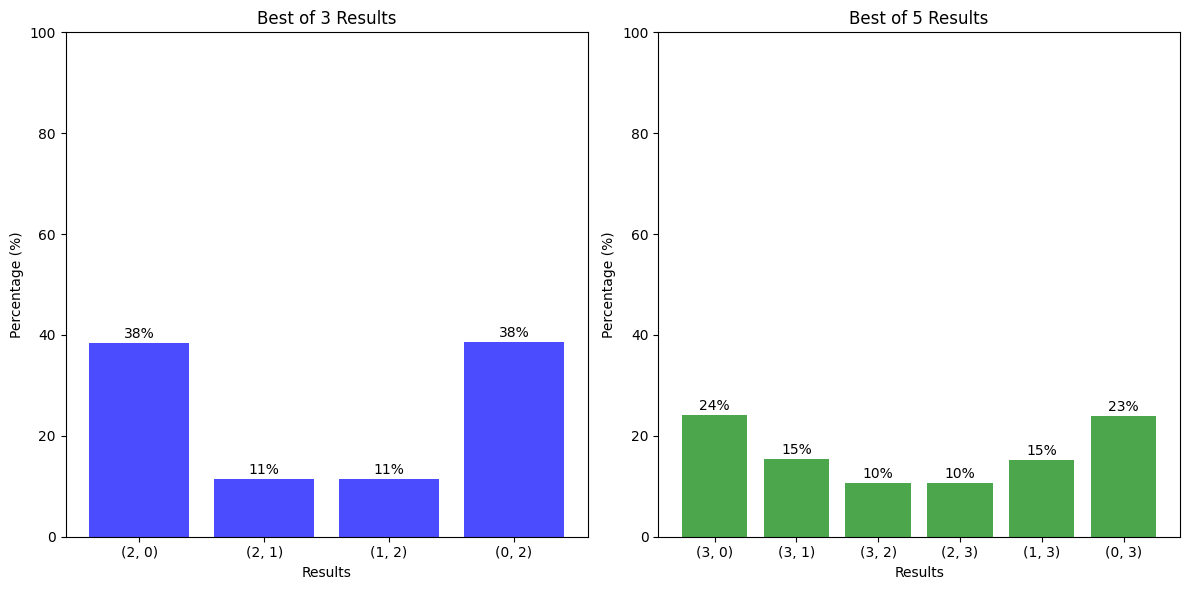

In [7]:
bo3_results = sets_df[(sets_df['best_of']==3) & (sets_df['valid_score']==True)][['p1_score','p2_score']]
bo3_result_ordered_labels = ['(2, 0)', '(2, 1)', '(1, 2)', '(0, 2)']

bo5_results = sets_df[(sets_df['best_of']==5) & (sets_df['valid_score']==True)][['p1_score','p2_score']]
bo5_result_ordered_labels = ['(3, 0)', '(3, 1)', '(3, 2)', '(2, 3)', '(1, 3)', '(0, 3)']

# Calculate counts and percentages for Best of 3
bo3_counts = bo3_results.value_counts(subset=['p1_score', 'p2_score']).reindex(
    [(2, 0), (2, 1), (1, 2), (0, 2)], fill_value=0
)
bo3_percentages = (bo3_counts / bo3_counts.sum()) * 100

# Calculate counts and percentages for Best of 5
bo5_counts = bo5_results.value_counts(subset=['p1_score', 'p2_score']).reindex(
    [(3, 0), (3, 1), (3, 2), (2, 3), (1, 3), (0, 3)], fill_value=0
)
bo5_percentages = (bo5_counts / bo5_counts.sum()) * 100

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Best of 3 histogram
axes[0].bar(bo3_result_ordered_labels, bo3_percentages, color='blue', alpha=0.7)
axes[0].set_title('Best of 3 Results')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xlabel('Results')
axes[0].set_ylim(0, 100)
for i, pct in enumerate(bo3_percentages):
    axes[0].text(i, pct + 1, f'{int(pct)}%', ha='center')

# Plot Best of 5 histogram
axes[1].bar(bo5_result_ordered_labels, bo5_percentages, color='green', alpha=0.7)
axes[1].set_title('Best of 5 Results')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Results')
axes[1].set_ylim(0, 100)
for i, pct in enumerate(bo5_percentages):
    axes[1].text(i, pct + 1, f'{int(pct)}%', ha='center')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


It is interesting that the most common score in a set is as shutout.

## Extract character data
First restrict to sets with game data.

In [8]:
sets_with_game_data_df = sets_df[sets_df['game_data'].apply(lambda x: x != [])].copy()
sets_with_game_data_df = sets_with_game_data_df[sets_with_game_data_df['valid_score'] == True]
sets_with_game_data_df['length_gamedata'] = sets_with_game_data_df['game_data'].apply(len)
sets_with_game_data_df = sets_with_game_data_df[sets_with_game_data_df['length_gamedata'].isin([2,3,4,5])]
sets_with_game_data_df.shape
print(f"Sets with game data comprise {sets_with_game_data_df.shape[0]/sets_df.shape[0]:.2%} of the data.")

Sets with game data comprise 30.13% of the data.


In [9]:

tqdm.pandas()

# Updated function to extract character and matchup data as strings
def extract_character_data(game_data, p1_id, p2_id):
    p1_characters = set()
    p2_characters = set()
    matchup_strings = []
    p1_initial_char = None
    p2_initial_char = None
    p1_changed = False
    p2_changed = False

    for game in game_data:
        # Extract winner and loser IDs
        winner_id = str(game['winner_id'])
        loser_id = str(game['loser_id'])

        # Extract characters
        winner_char = game['winner_char'].split('/')[1] if game['winner_char'] else None
        loser_char = game['loser_char'].split('/')[1] if game['loser_char'] else None

        # Skip if either character is missing
        if not winner_char or not loser_char:
            continue

        # Track unique characters for Player 1
        if winner_id == p1_id:
            p1_characters.add(winner_char)
            if p1_initial_char is None:
                p1_initial_char = winner_char
            elif winner_char != p1_initial_char:
                p1_changed = True
        elif loser_id == p1_id:
            p1_characters.add(loser_char)
            if p1_initial_char is None:
                p1_initial_char = loser_char
            elif loser_char != p1_initial_char:
                p1_changed = True

        # Track unique characters for Player 2
        if winner_id == p2_id:
            p2_characters.add(winner_char)
            if p2_initial_char is None:
                p2_initial_char = winner_char
            elif winner_char != p2_initial_char:
                p2_changed = True
        elif loser_id == p2_id:
            p2_characters.add(loser_char)
            if p2_initial_char is None:
                p2_initial_char = loser_char
            elif loser_char != p2_initial_char:
                p2_changed = True

        # Create matchup string
        p1_char = winner_char if winner_id == p1_id else loser_char
        p2_char = winner_char if winner_id == p2_id else loser_char
        winner = '0' if winner_id == p1_id else '1'
        matchup_strings.append(f"{p1_char}/{p2_char}/{winner}")

    return (
        sorted(p1_characters),  # Unique characters played by Player 1
        sorted(p2_characters),  # Unique characters played by Player 2
        p1_changed,             # True if Player 1 changed characters
        p2_changed,             # True if Player 2 changed characters
        matchup_strings         # List of matchup strings
    )

# Apply the function to the DataFrame
sets_with_game_data_df[['p1_characters', 'p2_characters', 'p1_changed', 'p2_changed', 'matchup_strings']] = sets_with_game_data_df.progress_apply(
    lambda row: pd.Series(extract_character_data(row['game_data'], str(row['p1_id']), str(row['p2_id']))),
    axis=1
)

# Add columns to indicate if players did not change characters
sets_with_game_data_df['p1_consistent'] = ~sets_with_game_data_df['p1_changed']
sets_with_game_data_df['p2_consistent'] = ~sets_with_game_data_df['p2_changed']

# Display the structure of the updated DataFrame
sets_with_game_data_df[['p1_characters', 'p2_characters', 'p1_consistent', 'p2_consistent', 'matchup_strings']].head()


100%|██████████| 541084/541084 [00:35<00:00, 15364.85it/s]


,p1_characters,p2_characters,p1_consistent,p2_consistent,matchup_strings
19575,[fox],[marth],True,True,"[fox/marth/1, fox/marth/1]"
19582,[jigglypuff],[marth],True,True,"[jigglypuff/marth/0, jigglypuff/marth/0]"
19626,[captainfalcon],[sheik],True,True,"[captainfalcon/sheik/0, captainfalcon/sheik/0]"
19628,[sheik],[falco],True,True,"[sheik/falco/0, sheik/falco/0]"
19629,[jigglypuff],[captainfalcon],True,True,"[jigglypuff/captainfalcon/0, jigglypuff/captai..."


Add the start and end date of the tournament.

In [10]:
sets_with_start_end_df = pd.merge(sets_df, tournament_info_df[['key','start','end']], how='left', left_on='tournament_key', right_on='key')
sets_with_start_end_df.head(3)
# sets_with_start_end_df.shape

,key_x,game,tournament_key,winner_id,loser_id,p1_id,p2_id,p1_score,p2_score,valid_score,...,set_order,game_data,top_8,top_8_location_names,valid_top_8_bracket,top_8_bracket_location_names,major,key_y,start,end
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),5620,Chillin,Chillin,5620,1,3,True,...,A,[],False,,False,,False,mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,2017-11-26 08:48:09
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),Aglet,15634,Aglet,15634,3,2,True,...,B,[],False,,False,,False,mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,2017-11-26 08:48:09
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),6126,1097,1097,6126,0,3,True,...,C,[],False,,False,,False,mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,2017-11-26 08:48:09


In [ ]:
# Generate the array of dates with weekly intervals
weekly_dates = np.arange(np.datetime64('2015-01-01'), np.datetime64('2024-11-08'), np.timedelta64(7, 'D'))


# Ensure valid dates
sets_with_start_end_df['start'] = pd.to_datetime(sets_with_start_end_df['start'], errors='coerce')

# Apply the function with robust handling
tqdm.pandas()
sets_with_start_end_df['start_week'] = sets_with_start_end_df['start'].progress_apply(
    lambda x: (
        max(np.argmax(weekly_dates > np.datetime64(x)) - 1, 0)
        if pd.notnull(x) and np.any(weekly_dates > np.datetime64(x))
        else 0
    )
)

sets_with_start_end_df['end_week'] = sets_with_start_end_df['end'].progress_apply(
    lambda x: (
        max(np.argmax(weekly_dates > np.datetime64(x)), 0)
        if pd.notnull(x) and np.any(weekly_dates > np.datetime64(x))
        else 1
    )
)
# Display the updated DataFrame
sets_with_start_end_df[['start','end','start_week','end_week']].head()
# sets_with_start_end_df['start_week'].info()

  0%|          | 0/1795681 [00:00<?, ?it/s]

100%|██████████| 1795681/1795681 [00:20<00:00, 88016.52it/s]


,start,end,start_week,end_week
0,2017-11-26 08:05:11,2017-11-26 08:48:09,151,152
1,2017-11-26 08:05:11,2017-11-26 08:48:09,151,152
2,2017-11-26 08:05:11,2017-11-26 08:48:09,151,152
3,2017-11-26 08:05:11,2017-11-26 08:48:09,151,152
4,2017-11-26 08:05:11,2017-11-26 08:48:09,151,152


In [30]:
sets_with_start_end_df[['start','end','start_week','end_week']].tail()

,start,end,start_week,end_week
1795676,2024-06-23 13:00:00,2024-06-23 20:00:00,494,495
1795677,2024-06-23 13:00:00,2024-06-23 20:00:00,494,495
1795678,2024-06-23 13:00:00,2024-06-23 20:00:00,494,495
1795679,2024-06-23 13:00:00,2024-06-23 20:00:00,494,495
1795680,2024-06-23 13:00:00,2024-06-23 20:00:00,494,495


In [25]:
tournament_info_df['start'].info()
print(sets_df['tournament_key'].nunique())
print(tournament_info_df['key'].nunique())
missing_keys = sets_df[~sets_df['tournament_key'].isin(tournament_info_df['key'])]
print(f"Missing keys in tournament_info_df: {missing_keys['tournament_key'].unique()}")


<class 'pandas.core.series.Series'>
RangeIndex: 39675 entries, 0 to 39674
Series name: start
Non-Null Count  Dtype         
--------------  -----         
39675 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 310.1 KB
39487
39675
Missing keys in tournament_info_df: []


In [26]:
sets_with_start_end_df[['start','end','start_week']].head()
sets_with_start_end_df['start']
sets_df = sets_with_start_end_df

In [27]:
# Add the specified columns to sets_df with default values
for col in ['p1_characters', 'p2_characters', 'p1_consistent', 'p2_consistent', 'matchup_strings']:
    sets_df[col] = None  # Default value is None; you can replace with np.nan if needed

# Update values in sets_df for sets present in sets_with_game_data_df
sets_df.update(sets_with_game_data_df[['p1_characters', 'p2_characters', 'p1_consistent', 'p2_consistent', 'matchup_strings']])

# Display the updated sets_df to verify
sets_df[['p1_characters', 'p2_characters', 'p1_consistent', 'p2_consistent', 'matchup_strings']].head()

,p1_characters,p2_characters,p1_consistent,p2_consistent,matchup_strings
0,None,None,None,None,None
1,None,None,None,None,None
2,None,None,None,None,None
3,None,None,None,None,None
4,None,None,None,None,None


In [28]:
sets_df.to_pickle(data_path + 'labelled_sets_df.pkl')

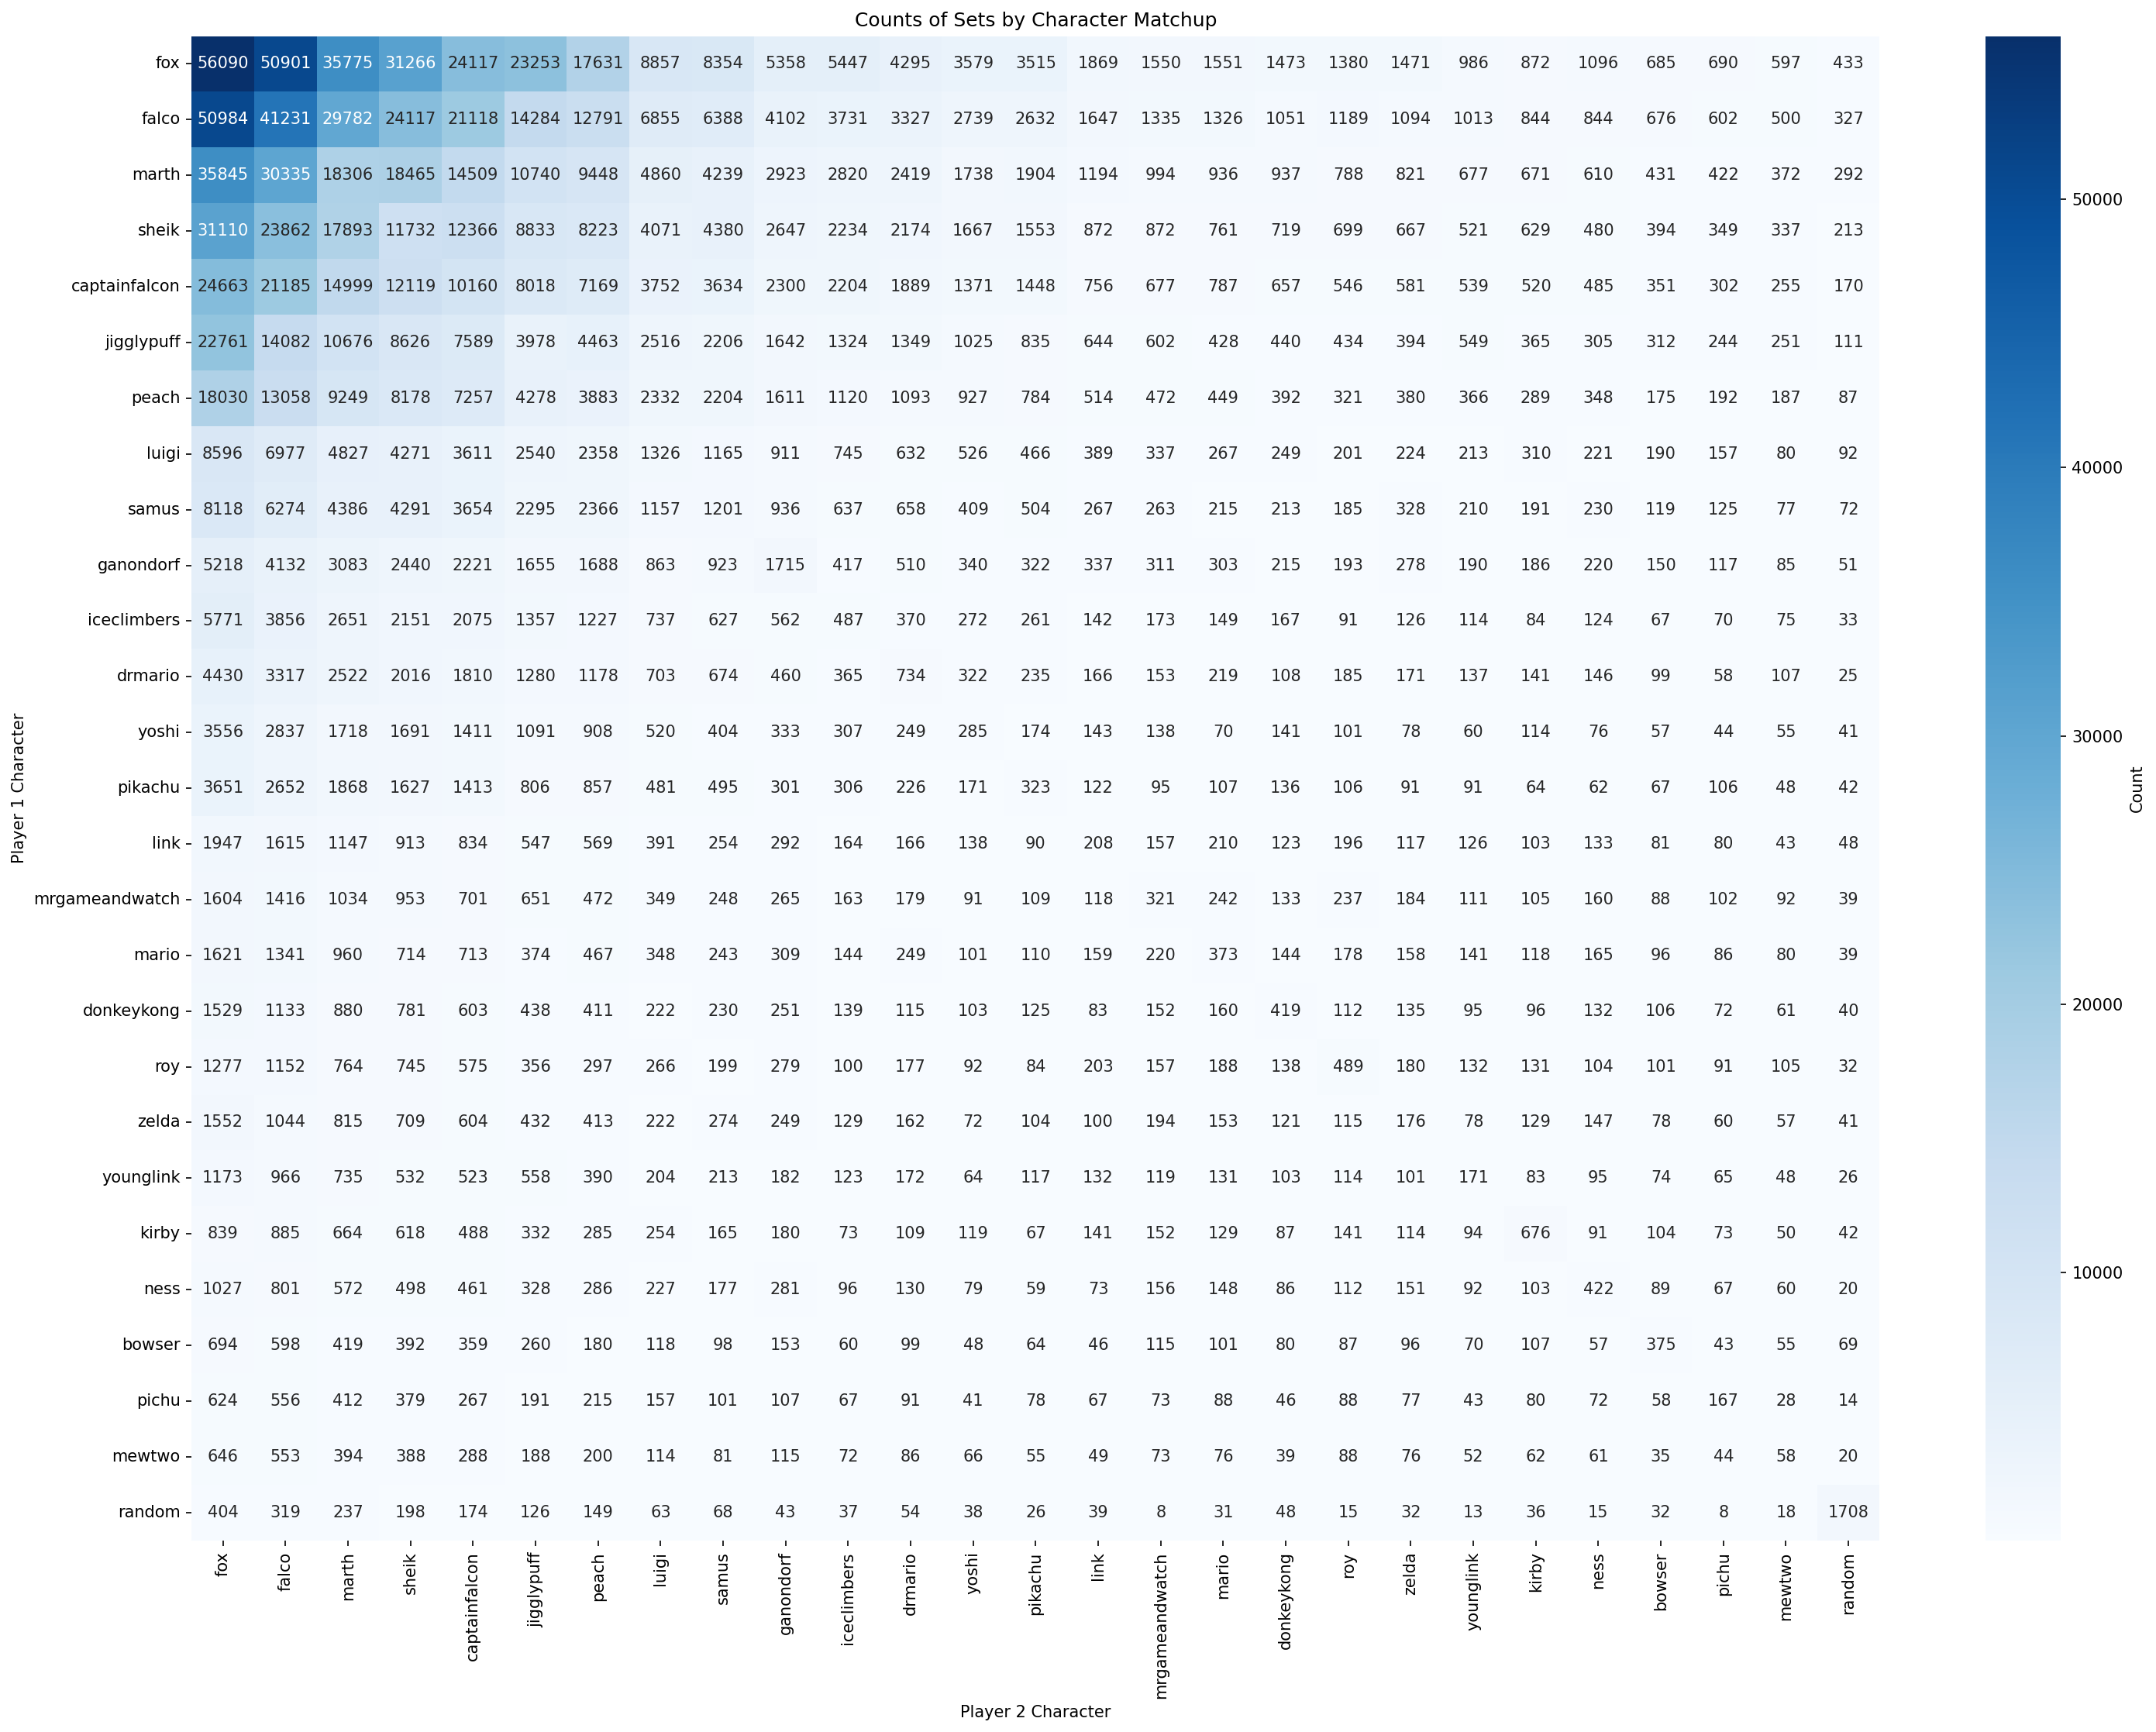

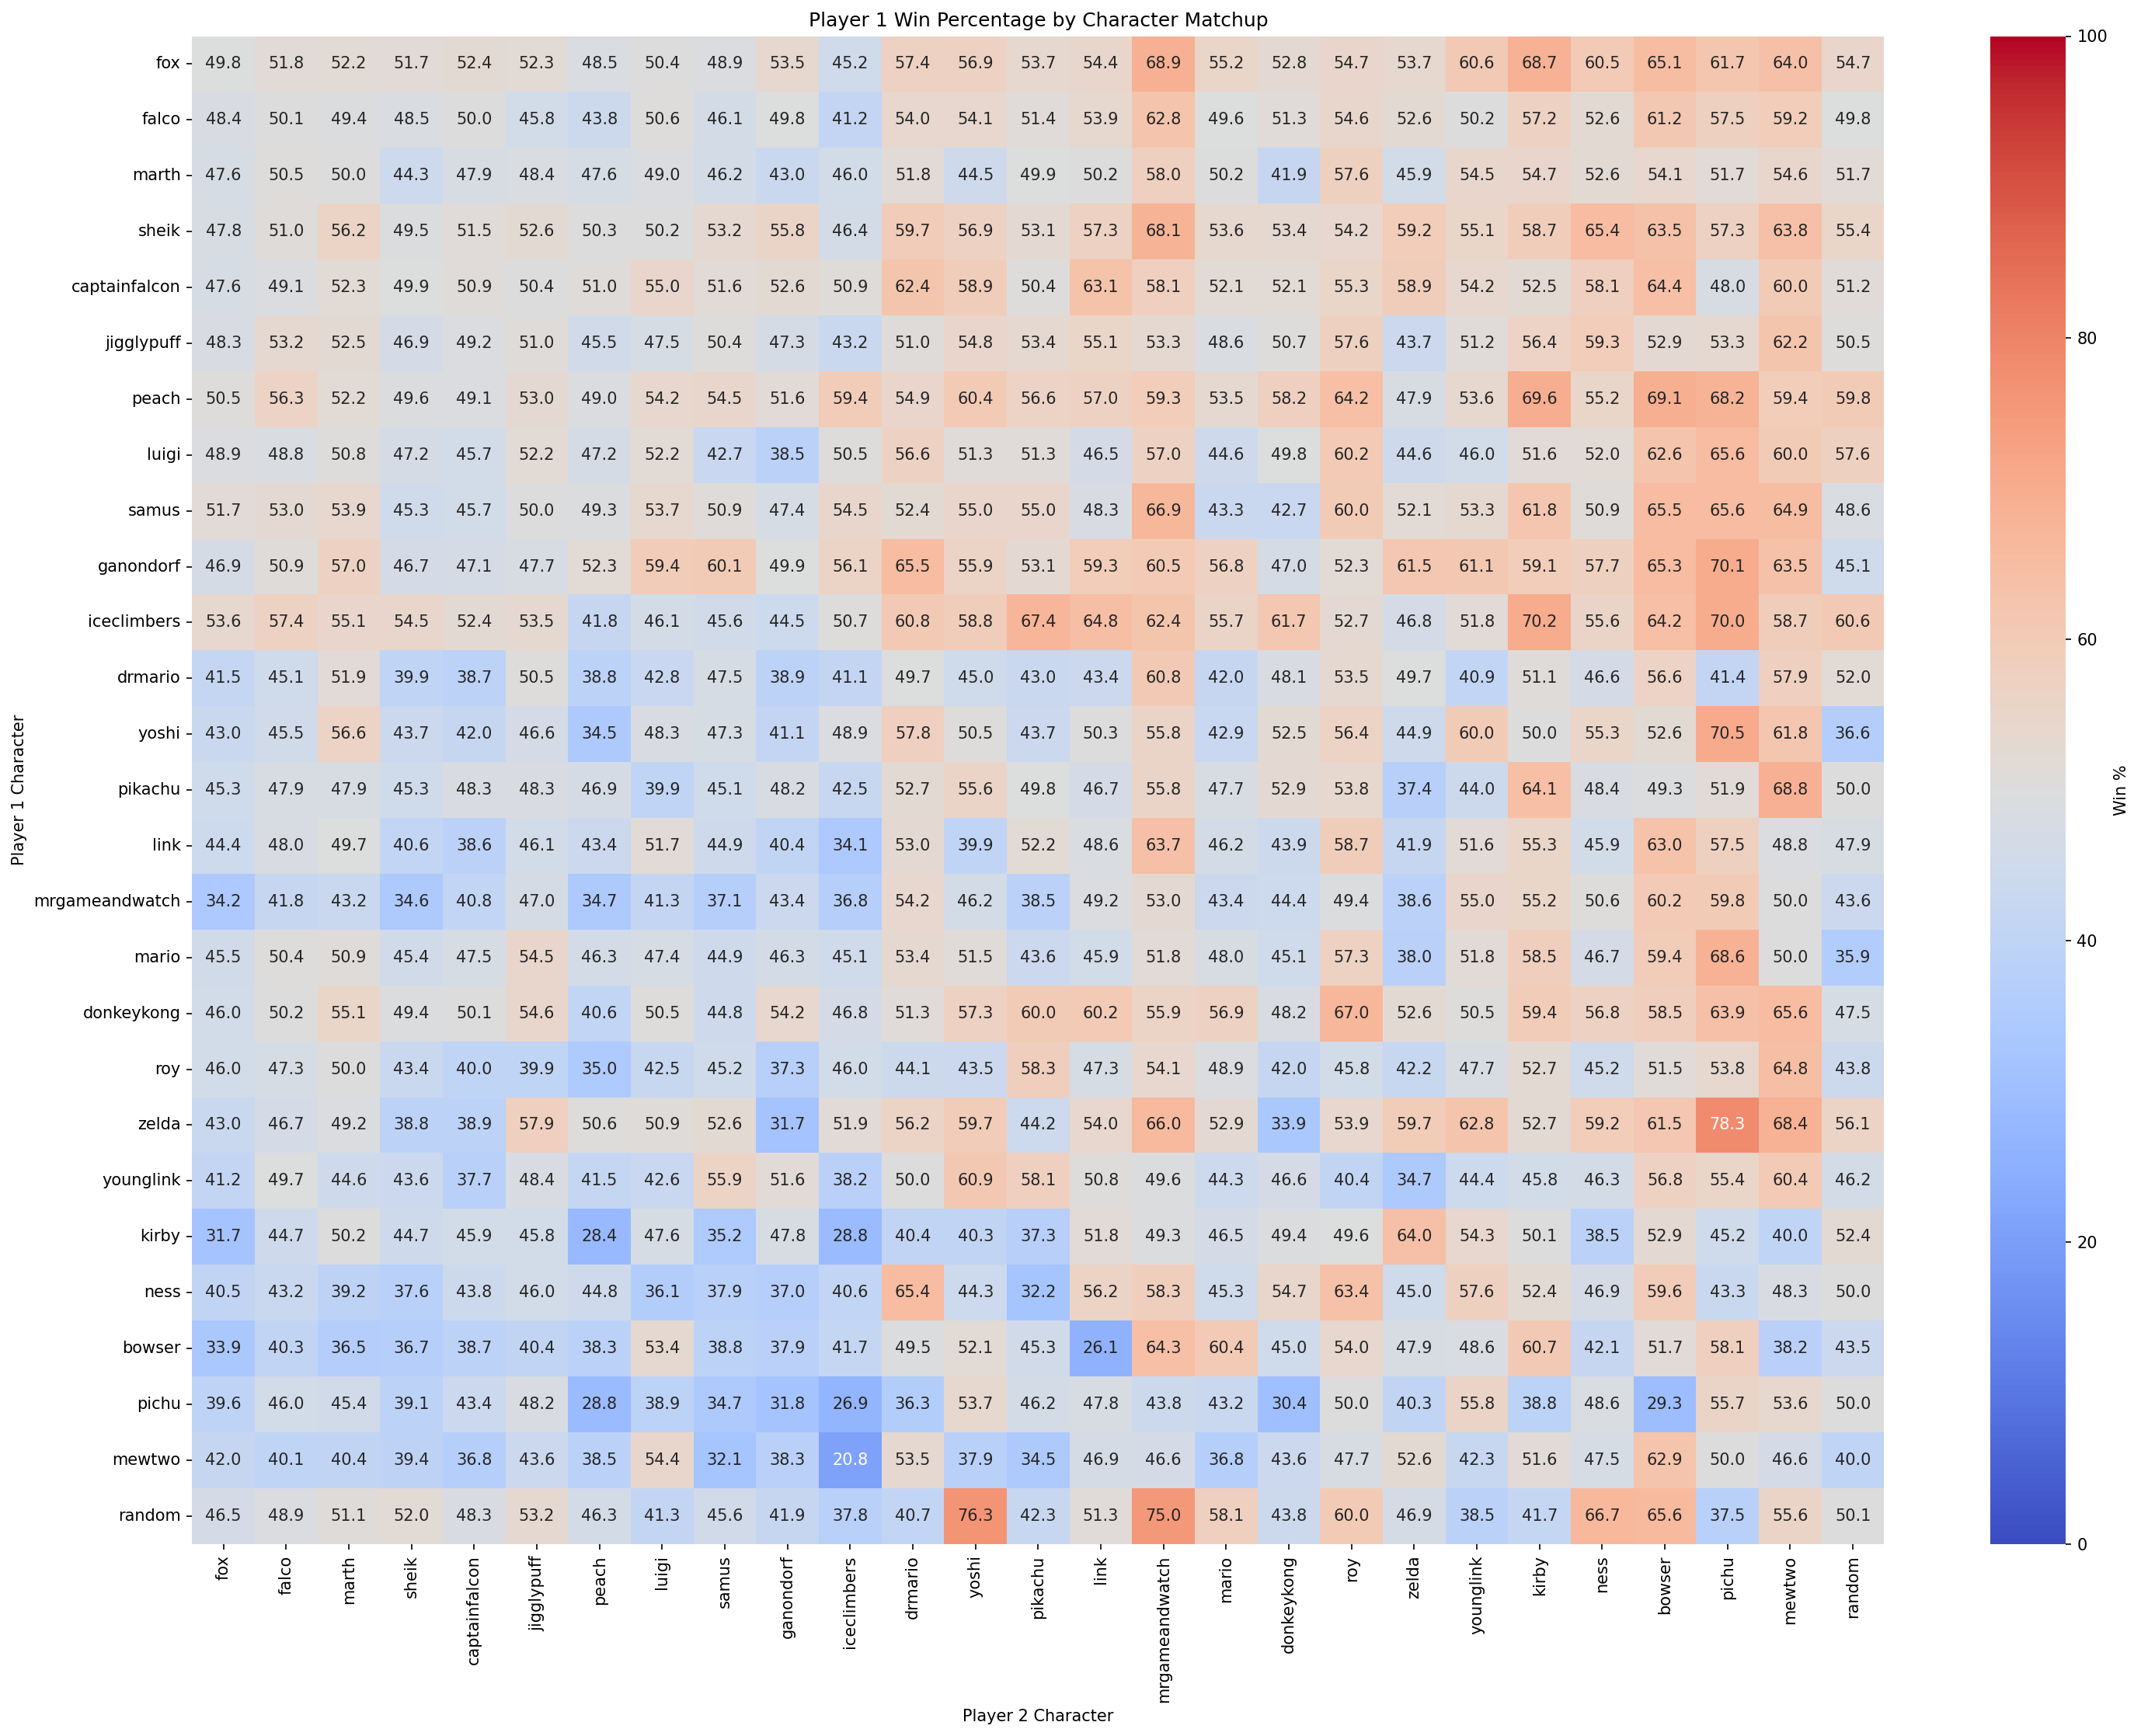

In [14]:


# Combine all matchup strings into a single list
all_matchup_strings = [matchup for matchup_list in sets_with_game_data_df['matchup_strings'] for matchup in matchup_list]

# Count occurrences of each matchup string
matchup_string_counts = Counter(all_matchup_strings)

# Prepare data for heatmaps
matchup_data = []
for matchup, count in matchup_string_counts.items():
    p1_char, p2_char, winner = matchup.split('/')
    p1_wins = int(winner == '0') * count  # Count wins for Player 1
    p2_wins = int(winner == '1') * count  # Count wins for Player 2
    matchup_data.append((p1_char, p2_char, count, p1_wins, p2_wins))

# Convert to DataFrame
matchup_df = pd.DataFrame(matchup_data, columns=['p1_char', 'p2_char', 'count', 'p1_wins', 'p2_wins'])

# Group by characters to calculate total counts and win rates
grouped = matchup_df.groupby(['p1_char', 'p2_char']).agg(
    total_sets=('count', 'sum'),
    p1_wins=('p1_wins', 'sum'),
    p2_wins=('p2_wins', 'sum')
).reset_index()

# Calculate win rate for Player 1
grouped['p1_win_rate'] = grouped['p1_wins'] / grouped['total_sets'] * 100

# Pivot tables for heatmaps
heatmap_data_counts = grouped.pivot(index='p1_char', columns='p2_char', values='total_sets').fillna(0)
heatmap_data_win_rate = grouped.pivot(index='p1_char', columns='p2_char', values='p1_win_rate').fillna(0)

# Order characters by frequency
char_order = heatmap_data_counts.sum(axis=1).sort_values(ascending=False).index
heatmap_data_counts = heatmap_data_counts.loc[char_order, char_order]
heatmap_data_win_rate = heatmap_data_win_rate.loc[char_order, char_order]

# Plot first heatmap (counts)
plt.figure(figsize=(20, 15), dpi=150)
sns.heatmap(heatmap_data_counts, annot=True, fmt='.0f', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Counts of Sets by Character Matchup')
plt.ylabel('Player 1 Character')
plt.xlabel('Player 2 Character')
plt.tight_layout()
plt.show()

# Plot second heatmap (win percentage)
plt.figure(figsize=(20, 15), dpi=150)
# Set midpoint for 50% winrate
norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)
sns.heatmap(
    heatmap_data_win_rate, 
    annot=True, 
    fmt='.1f', 
    cmap='coolwarm', 
    norm=norm, 
    cbar_kws={'label': 'Win %'}
)
plt.title('Player 1 Win Percentage by Character Matchup')
plt.ylabel('Player 1 Character')
plt.xlabel('Player 2 Character')
plt.tight_layout()
plt.show()


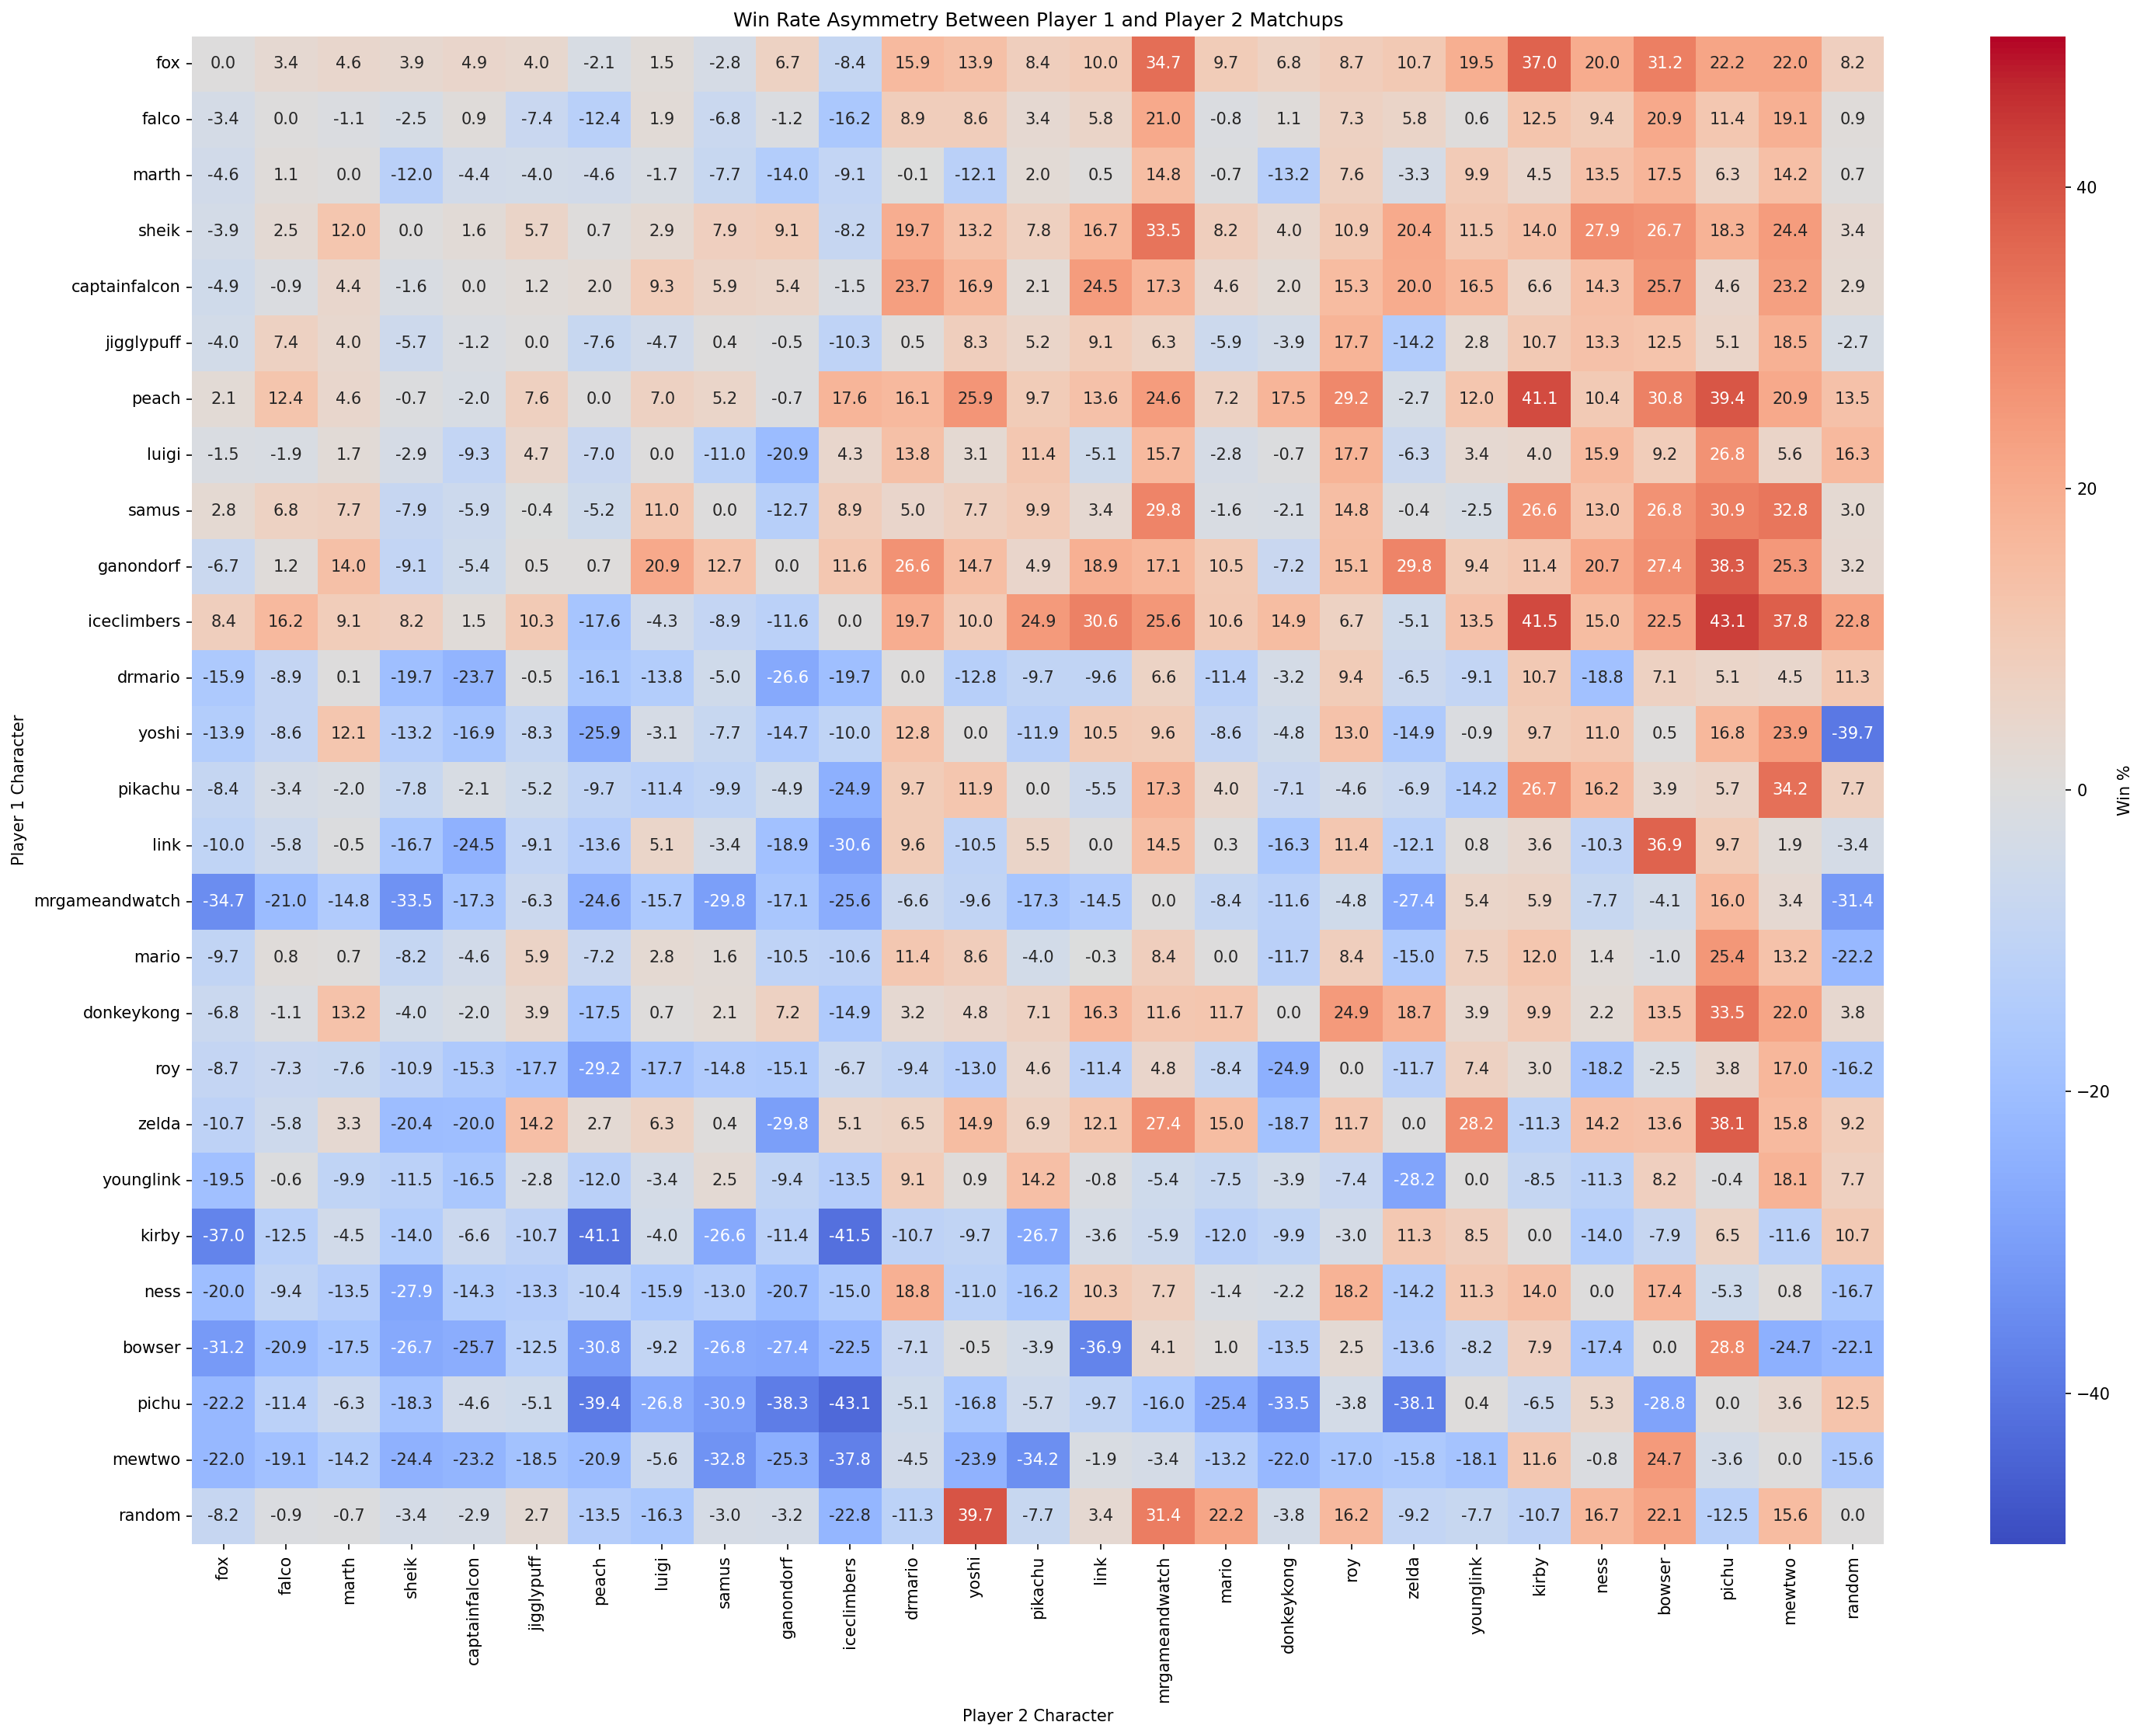

In [15]:
# Combine all matchup strings into a single list
all_matchup_strings = [matchup for matchup_list in sets_with_game_data_df['matchup_strings'] for matchup in matchup_list]

# Count occurrences of each matchup string
matchup_string_counts = Counter(all_matchup_strings)

# Prepare data for heatmaps
matchup_data = []
for matchup, count in matchup_string_counts.items():
    p1_char, p2_char, winner = matchup.split('/')
    p1_wins = int(winner == '0') * count  # Count wins for Player 1
    p2_wins = int(winner == '1') * count  # Count wins for Player 2
    matchup_data.append((p1_char, p2_char, count, p1_wins, p2_wins))

# Convert to DataFrame
matchup_df = pd.DataFrame(matchup_data, columns=['p1_char', 'p2_char', 'count', 'p1_wins', 'p2_wins'])

# Group by characters to calculate total counts and win rates
grouped = matchup_df.groupby(['p1_char', 'p2_char']).agg(
    total_sets=('count', 'sum'),
    p1_wins=('p1_wins', 'sum'),
    p2_wins=('p2_wins', 'sum')
).reset_index()

# Calculate win rate for Player 1
grouped['p1_win_rate'] = grouped['p1_wins'] / grouped['total_sets'] * 100

# Pivot tables for heatmaps
heatmap_data_counts = grouped.pivot(index='p1_char', columns='p2_char', values='total_sets').fillna(0)
heatmap_data_win_rate = grouped.pivot(index='p1_char', columns='p2_char', values='p1_win_rate').fillna(0)
heatmap_data_win_rate = heatmap_data_win_rate - heatmap_data_win_rate.T
# Order characters by frequency
char_order = heatmap_data_counts.sum(axis=1).sort_values(ascending=False).index
heatmap_data_counts = heatmap_data_counts.loc[char_order, char_order]
heatmap_data_win_rate = heatmap_data_win_rate.loc[char_order, char_order]

# # Plot first heatmap (counts)
# plt.figure(figsize=(20, 15), dpi=150)
# sns.heatmap(heatmap_data_counts, annot=True, fmt='.0f', cmap='Blues', cbar_kws={'label': 'Count'})
# plt.title('Counts of Sets by Character Matchup')
# plt.ylabel('Player 1 Character')
# plt.xlabel('Player 2 Character')
# plt.tight_layout()
# plt.show()

# Plot second heatmap (win percentage)
plt.figure(figsize=(20, 15), dpi=150)
# Set midpoint for 50% winrate
norm = TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
sns.heatmap(
    heatmap_data_win_rate, 
    annot=True, 
    fmt='.1f', 
    cmap='coolwarm', 
    norm=norm, 
    cbar_kws={'label': 'Win %'}
)
plt.title('Win Rate Asymmetry Between Player 1 and Player 2 Matchups')
plt.ylabel('Player 1 Character')
plt.xlabel('Player 2 Character')
plt.tight_layout()
plt.show()


,p1_characters,p2_characters,p1_consistent,p2_consistent,matchup_strings
0,None,None,None,None,None
1,None,None,None,None,None
2,None,None,None,None,None
3,None,None,None,None,None
4,None,None,None,None,None


### Save the dataframe